 # LACONEU 2025: Methods of Information Theory for Brain Data
 **Tutorial #2: Measuring Effect Size of O-information in Brain Regions for Anesthesia Data**

 ## Overview
 In this tutorial, we analyze functional MRI (fMRI) data from 16 subjects who each underwent two conditions:
 1. **Wakefulness** at rest (labeled "Wake")
 2. **Deep anesthesia** (labeled "Deep")

 Our primary goal is to measure how O-information (a higher-order informational measure) differs between these two states and to quantify the effect size of these differences across multiple brain regions to obtain those brain regions where the activity varies the most across states according with the O-information. We will do this using custom metrics within the THOI framework.

 ## Data Description
 - **Original Source**: The dataset was published in [1].
 - **Size & Format**: All data are stored in a single TSV (tab-separated values) file.
 - **Number of Regions**: 55 brain regions are grouped into 11 distinct networks, each containing 5 regions.
 - **Rows & Columns**:
   - **Columns**:
     - `sub`: Subject ID, ranging from 1 to 16
     - `state`: Either "Wake" (resting wakefulness) or "Deep" (deep anesthesia)
     - 55 additional columns: Each is a time series from a specific brain region
       - These 55 columns are hierarchically labeled in the TSV by `(network, region_number)`
   - **Rows**:
     - For each unique `(subject, state)` pair, there are **245 consecutive rows** (time points).

 ## Matrix Construction (Xs Matrices)
 From this TSV file, we create **32** data matrices (Xs), each of shape \((245, 55)\). These matrices follow the order:
 1. **Wake** for subjects 1 through 16
 2. **Deep** for subjects 1 through 16

 Each matrix represents one subject’s entire time series (245 time points) across all 55 regions.

 ## THOI & Custom Metrics
 - **Multiple Datasets**: THOI can process batches of multiple datasets (in our case, these 32 matrices) in a single run.
 - **Custom Metrics**: When using heuristics like *greedy* or *simulated annealing* in THOI, we can pass a custom metric function. This function receives a batch of data with shape (batch_size, n_datasets, 4):
   1. **batch_size**: Number of nplets (subsets of regions) being evaluated in parallel
   2. **n_datasets**: Number of datasets being processed (32 here)
   3. **4**: The four HOI measures returned by THOI in the order (DTC, TC, O, S)
 - **Metric Return Value**: The custom metric must return a single scalar value per nplet (i.e., per item in the batch) indicating its “performance.”

 ## Effect Size Calculation
 In this tutorial, we use **Cohen’s d** to quantify the effect size of the O-information differences between Awake and Deep states:
 1. Compute the O-information for each subject in both Wake and Deep states for a given nplet (done in parallel).
 2. Calculate the paired effect size (Awake vs. Deep) across subjects.
 
 For more details on Cohen’s d, see [the Pingouin documentation](https://pingouin-stats.org/generated/pingouin.compute_effsize.html).

 ## References
 [1] **Nemirovsky, I. E. et al.** An implementation of integrated information theory in resting-state fMRI. *Communications Biology*, **6**, 692 (2023).


In [1]:
import pandas as pd
import torch
import pingouin as pg
from matplotlib.patches import Patch
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import wilcoxon

from thoi.heuristics import greedy
from thoi.heuristics.simulated_annealing_multi_order import simulated_annealing_multi_order
from thoi.measures.gaussian_copula import nplets_measures

# Plotting functions

In [2]:
state_colors = {
    'Awake': sns.color_palette()[2],
    'Deep': sns.color_palette()[4]
}

def plot_whale_curve_state(df, state, ax):
    
    # get the blue and orange seaborn default colors
    color = state_colors[state]
    
    df_state = df[df['label'].str.contains(state)]

    # Plot the greedy search results 
    sns.lineplot(
        x='order',
        y='o',
        data=df_state[df_state['label'].str.contains('Greedy Max')],
        color=color,
        label=rf'$Greedy(\Omega({state}))$',
        ax=ax
    )
    sns.lineplot(
        x='order',
        y='o',
        data=df_state[df_state['label'].str.contains('Greedy Min')],
        color=color,
        ax=ax
    )

    plt.fill_between(
        df_state[df_state['label'].str.contains('Greedy Min')]['order'],
        df_state[df_state['label'].str.contains('Greedy Min')]['o'],
        df_state[df_state['label'].str.contains('Greedy Max')]['o'],
        alpha=0.2, color=color,
    )


def plot_whale_curves(df):

    fig, ax = plt.subplots(figsize=(1.2*6.4, 6.8))

    plot_whale_curve_state(df, 'Awake', ax)
    plot_whale_curve_state(df, 'Deep', ax)

    # Eliminamos esa information porque queda muy cargado
    ax.get_legend().remove()

    # add une legends with two filled squared blue and orange with labels ['Awake', 'Deep']
    state_legend = plt.legend(
        handles=[
            Patch(facecolor=state_colors['Awake'], edgecolor=state_colors['Awake'], label='Awake'),
            Patch(facecolor=state_colors['Deep'], edgecolor=state_colors['Deep'], label='Deep')
        ],
        labels=['Awake', 'Deep'],
        title='State',
        loc='lower right'
    )

    plt.xlabel('Order')
    plt.ylabel(r'$\Omega$')

    plt.tight_layout()
    plt.show()


def plot_effect_size_contrast(Xs, nplet, metric = 'o', text_left=True, text_top=False):
    
    # Size to fit 4 instead of 3 horizontal
    fig, ax = plt.subplots(figsize=(4.8, 5.1))
    
    order = nplet.shape[0]
    metric_idx = ['dtc', 'tc', 'o', 's'].index(metric)
    
    o = nplets_measures(Xs, nplet.reshape(1, -1))[0, :, metric_idx]

    x = o[:len(o) // 2]
    y = o[len(o) // 2:]

    pval = wilcoxon(x, y, alternative='two-sided').pvalue
    effect_size = pg.compute_effsize(y, x, eftype='cohen') # x and y inverted to have deep - awake

    df_greedy_best = pd.DataFrame({
        'o': o,
        'subject': np.concatenate([np.arange(16), np.arange(16)]),
        'state': np.concatenate([np.repeat('Awake', 16), np.repeat('Deep', 16)])
    })

    # Plot violin plots of the best nplets with state in the x acess and o in the y axis
    sns.violinplot(
        data=df_greedy_best,
        x='state',
        y='o',
        cut=0,
        alpha=0.5,
        palette=state_colors,
        legend=False,
        ax=ax
    )

    # add stripplot and connect the dots between the same subjects
    sns.stripplot(
        data=df_greedy_best,
        x='state',
        y='o',
        jitter=False,          # Disable jitter for alignment
        size=8,
        palette=state_colors,
        edgecolor='auto',
        alpha=0.7,
        ax=ax
    )

    # Connect each subject's paired measurements with lines
    for subject, subject_data in df_greedy_best.groupby('subject'):
        subject_data = subject_data.sort_values('state')
        plt.plot(
            subject_data['state'],
            subject_data['o'],
            marker='o',
            color='black',
            alpha=0.5,
            linewidth=1
        )

    #ax.set_title(f'order: {order} - p-value: {pval:.2e} - Effect size: {effect_size:.2f}')
    ax.set_xlabel('State')
    #ax.set_ylabel(r'$\Omega$')
    ax.set_ylabel('')

    textstr = f'Order: {order}\np: {pval:.2e}\nd: {effect_size:.2f}'

    # Add the text to the plot
    ax.text(0.05 if text_left else 0.5,
            0.95 if not text_top else 1.25,
            textstr,
            transform=ax.transAxes,
            fontsize=18,
            verticalalignment='top')

    #plt.axhline(0, color='black', linestyle='--')

    n_states = 2 # Awake and Deep
    plt.xlim(-0.5, n_states - 0.5)

    plt.tight_layout()
    plt.show()


def plot_optimized_effect_sizes_by_order(scores_greedy_max, scores_greedy_min):
    max_best_order = scores_greedy_max.mean(axis=0).argmax()+3
    max_score = scores_greedy_max.max()

    print('Order with maximum mean effect size:', max_best_order)

    blue = sns.color_palette()[0]
    red = sns.color_palette()[3]

    df_scores_greedy = pd.DataFrame([
        (o+3, r, scores_greedy_max[r, o])
        for o in range(scores_greedy_max.shape[1])
        for r in range(scores_greedy_max.shape[0])
    ], columns=['order', 'repeat', 'score'])

    fig, ax = plt.subplots(figsize=(1.2*6.4, 6.8))

    sns.lineplot(
        x=df_scores_greedy['order'],
        y=df_scores_greedy['score'],
        data=df_scores_greedy,
        dashes=False, 
        label='Effect size maximization',
        errorbar=lambda x: (x.min(), x.max()),
        color=red,
        ax=ax
    )

    # Plot a line in the maximum mean o from zero to top height
    ax.axvline(max_best_order, color='red', linestyle='--', ymin=0.5, ymax=1)

    # Plot effect size minimization

    best_order = scores_greedy_min.mean(axis=0).argmin()+3
    min_score = scores_greedy_min.min()

    print('Order with minimum mean effect size:', best_order)

    df_scores_greedy = pd.DataFrame([
        (o+3, r, scores_greedy_min[r, o])
        for o in range(scores_greedy_min.shape[1])
        for r in range(scores_greedy_min.shape[0])
    ], columns=['order', 'repeat', 'score'])

    sns.lineplot(
        x=df_scores_greedy['order'],
        y=df_scores_greedy['score'],
        data=df_scores_greedy,
        dashes=False,
        label='Effect size minimization',
        errorbar=lambda x: (x.min(), x.max()),
        color=blue,
        ax=ax
    )

    # Plot a line in the minimum mean o
    ax.axvline(best_order, color='red', linestyle='--', ymin=0.5, ymax=0)

    # Make y limits symetric
    max_score = max(max_score, -min_score)* 1.1
    ax.set_ylim(-max_score, max_score)

    # plot zero line
    ax.axhline(0, color='black', linestyle='--')

    # Plot the best order for the maximization
    ax.set_xlim(0,df_scores_greedy['order'].max())

    ax.set_xlabel('Order')
    ax.set_ylabel('Effect size')
    #ax.set_yscale('log')

    # set x ticks at 5, 10, 15, 20, 25, ...
    ax.set_xticks(np.arange(5, 56, 5))

    plt.tight_layout()
    plt.show()

# Auxiliary functions

In [3]:
def greedy_to_df(scores, label):
    
    if 'Max' in label:
        best_score = scores.max(axis=0)
    else:
        best_score = scores.min(axis=0)

    orders = np.arange(3, 56)
    
    return pd.DataFrame({
        'order': orders,
        'label': label,
        'o': best_score
    })

# Read and process the data

In [15]:
# Read the data in tsv format
df = pd.read_csv('/home/laouen.belloli/Documents/anesthesia.tsv', sep='\t', header=[0,1])
a = df.columns.get_level_values(level=0)
b = [c if 'Unnamed' not in c else '' for c in df.columns.get_level_values(level=1)]
df.columns = [a, b]
display(df)

sub  state VentralAttn                         CinguloParie              \
                          0     1     2     3     4            0     1     2   
0     12  Awake       -0.26  0.50  0.36  0.12  0.33        -0.04 -0.14 -0.03   
1     12  Awake       -0.56  0.01 -0.13  0.15 -0.23         0.75 -0.56 -0.79   
2     12  Awake       -0.67  0.34 -0.18  0.26  0.13         1.09 -0.53 -0.67   
3     12  Awake       -0.64  1.28  0.22  0.49  1.32         0.93 -0.02  0.26   
4     12  Awake       -0.62  1.77  0.69  0.75  2.35         0.58  0.54  1.12   
...   ..    ...         ...   ...   ...   ...   ...          ...   ...   ...   
7835   5   Deep       -0.45 -0.27  1.06  0.55  1.01        -2.20  0.66 -0.26   
7836   5   Deep        0.08 -0.07  1.26  0.46  1.48        -2.35  0.96  0.28   
7837   5   Deep        0.68  0.01  0.91  0.11  1.36        -1.73  0.92  0.93   
7838   5   Deep        0.68  0.01  0.37 -0.17  0.78        -0.86  0.57  0.88   
7839   5   Deep       -0.00  0.01 -0.09 -0.24  0.02        -0.10  0.04  0.05   

      ... DorsalAttn                         FrontoParietal                    \
      ...          0     1     2     3     4              0     1     2     3   
0     ...      -0.02  0.20 -0.14  0.08  0.07           0.27  0.07  0.13  0.16   
1     ...      -0.81 -1.36 -1.52 -0.71  0.13          -1.06 -1.06 -0.32  0.31   
2     ...      -0.98 -2.05 -2.35 -1.16  0.09          -1.40 -1.42 -0.30  0.44   
3     ...      -0.45 -1.66 -2.36 -1.11  0.04          -0.60 -0.86  0.19  0.56   
4     ...       0.29 -0.70 -1.70 -0.65  0.21           0.58  0.07  0.75  0.71   
...   ...        ...   ...   ...   ...   ...            ...   ...   ...   ...   
7835  ...       1.32  0.23  0.24  2.04  2.31          -1.43 -0.39 -0.10  0.85   
7836  ...       0.83  0.44  0.48  2.47  1.45          -0.77 -0.36 -0.12  0.59   
7837  ...      -0.10  0.22  0.54  1.88  0.17           0.09 -0.16 -0.13  0.09   
7838  ...      -0.46 -0.07  0.34  0.89 -0.38           0.37  0.01 -0.13 -0.17   
7839  ...      -0.06 -0.22 -0.06 -0.01 -0.02          -0.00  0.08 -0.14 -0.10   

            
         4  
0    -0.23  
1    -0.90  
2    -1.31  
3    -1.32  
4    -0.95  
...    ...  
7835 -1.40  
7836 -1.30  
7837 -0.59  
7838 -0.04  
7839  0.09  

[7840 rows x 57 columns]

In [5]:
# Create the datasets from the data
networks = df.columns.get_level_values(0).unique()[2:]

Xs = [
    df[(df['sub'] == sub) & (df['state'] == state)][networks].values
    for state in sorted(df['state'].unique())
    for sub in sorted(df['sub'].unique())
]

subjects_states = pd.DataFrame([
    (sub, state)
    for state in sorted(df['state'].unique())
    for sub in sorted(df['sub'].unique())
], columns=['Subject ID', 'State'])
subjects_states['Dataset order'] = range(len(subjects_states))
display(subjects_states)

,Subject ID,State,Dataset order
0,1,Awake,0
1,2,Awake,1
2,3,Awake,2
3,4,Awake,3
4,5,Awake,4
5,6,Awake,5
6,7,Awake,6
7,8,Awake,7
8,9,Awake,8
9,11,Awake,9


# Whale chart for greedy max min by consciousn state (awake or deep)

In [6]:
# Compute the maximum and minimim O-information for both states
Xs_awake = Xs[:16]
Xs_deep = Xs[16:]

# Calculate for each order of interaction the maximum and minimum O-information for awake
nplets_awake_max, scores_awake_max = greedy(Xs_awake, repeat=50, metric='o', largest=True)
nplets_awake_min, scores_awake_min = greedy(Xs_awake, repeat=50, metric='o', largest=False)

# Calculate for each order of interaction the maximum and minimum O-information for Deep
nplets_deep_max, scores_deep_max = greedy(Xs_deep, repeat=50, metric='o', largest=True)
nplets_deep_min, scores_deep_min = greedy(Xs_deep, repeat=50, metric='o', largest=False)

# Convert all scores to numpy to plot them
scores_awake_max = scores_awake_max.cpu().numpy()
scores_awake_min = scores_awake_min.cpu().numpy()
scores_deep_max = scores_deep_max.cpu().numpy()
scores_deep_min = scores_deep_min.cpu().numpy()

# Join all the scores in a single dataframe 
df_greedy_awake_max = greedy_to_df(scores_awake_max, 'Awake Greedy Max')
df_greedy_awake_min = greedy_to_df(scores_awake_min, 'Awake Greedy Min')
df_greedy_deep_max = greedy_to_df(scores_deep_max, 'Deep Greedy Max')
df_greedy_deep_min = greedy_to_df(scores_deep_min, 'Deep Greedy Min')

df_whale = pd.concat([
    df_greedy_awake_max,
    df_greedy_awake_min,
    df_greedy_deep_max,
    df_greedy_deep_min
])

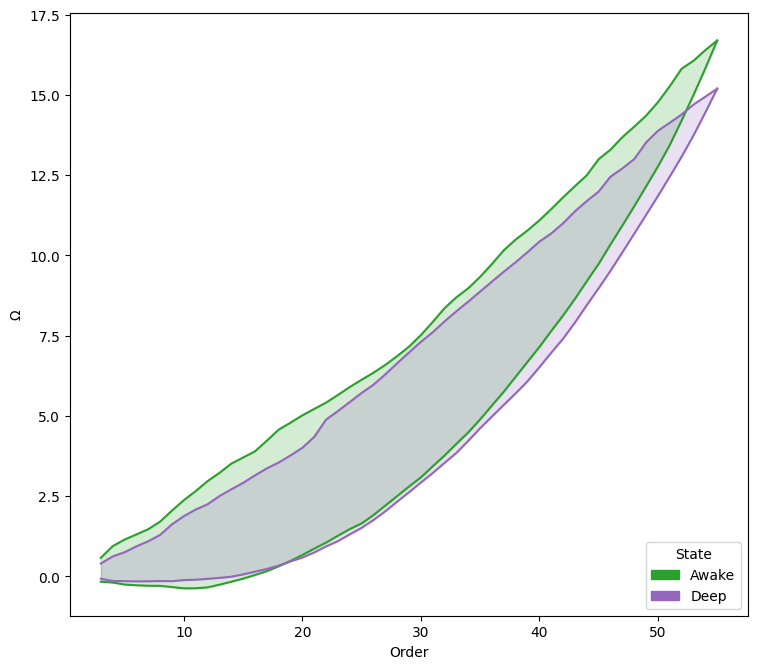

In [7]:
# Plot the Whale curves
plot_whale_curves(df_whale)

# optimizing over the O-information effect size

### Plot the entire brain O-information effect size contrast

/tmp/ipykernel_12427/1819393720.py:87: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/tmp/ipykernel_12427/1819393720.py:99: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(


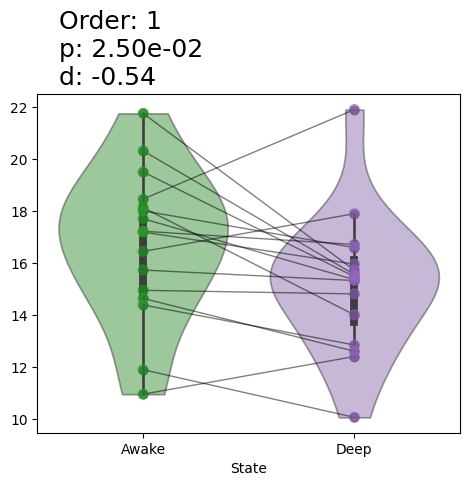

In [8]:
whole_brain_nplet = np.arange(55).reshape(1,-1)
plot_effect_size_contrast(Xs, whole_brain_nplet, text_top=True)

### Find the nplet that maximizes and minimizes the effect size between Awake and Deep states

1. Using the Greeedy algorithm, using the effect size function as the cost function
2. Using the cross order simulated annealing algorithm, using the effect size function as the cost function

In [9]:
def effect_size(batched_res: torch.Tensor, metric:str='o'):
    '''
    Get the effect size of the groups from the batched results.

    params:
    - batched_res (torch.Tensor): The batched results with shape (batch_size, D, 4) where 4 is the number of metrics (tc, dtc, o, s).
        D = 2*n_subjects = 2*16 = 32; Where [0, D/2) are subjects 1 to 16 in Awake state and [D/2, D) are subjects 1 to 16 in Deep state.
    - metric (str): The metric to test effect size. One of tc, dtc, o or s
    '''
    
    METRICS = ['tc', 'dtc', 'o', 's']
    metric_idx = METRICS.index(metric)
    
    # convert to numpy to process
    batched_res = batched_res.cpu().numpy()
    
    batch_size, D = batched_res.shape[:2]
    
    # |batch_size| x |D/2|
    group_awake = batched_res[:, :D//2, metric_idx]
    group_deep = batched_res[:, D//2:, metric_idx]
    
    # Positive effect size when group_deep > group_awake
    # |batch_size|
    effect_size = torch.tensor([
        pg.compute_effsize(group_deep[i], group_awake[i], paired=True, eftype='cohen')
        for i in range(batch_size)
    ])
    
    return effect_size

In [10]:
# Maximize and Minimize the effect size over the o-information to obtain a set of optimized nplets
nplets_greedy_max, scores_greedy_max = greedy(Xs, repeat=50, metric=effect_size, largest=True)
nplets_greedy_min, scores_greedy_min = greedy(Xs, repeat=50, metric=effect_size, largest=False)

# Convert the scores to numpy
scores_greedy_max = scores_greedy_max.cpu().numpy()
scores_greedy_min = scores_greedy_min.cpu().numpy()

### Plot the obtained nplets contrast using paired violing plots

/tmp/ipykernel_12427/1819393720.py:87: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/tmp/ipykernel_12427/1819393720.py:99: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(


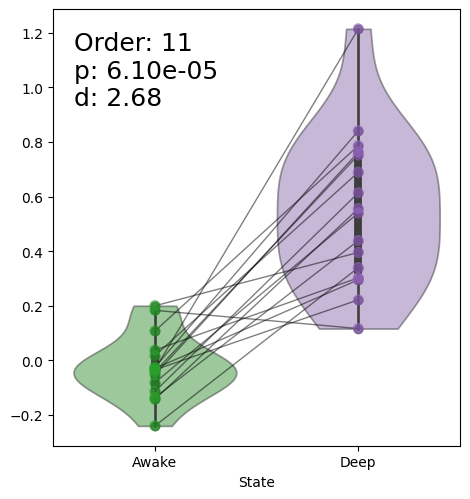

/tmp/ipykernel_12427/1819393720.py:87: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/tmp/ipykernel_12427/1819393720.py:99: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(


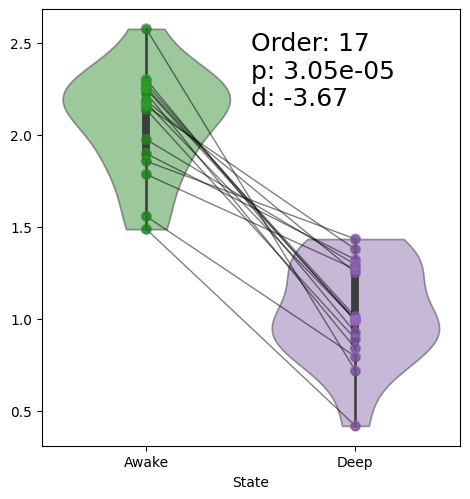

In [11]:
best_order_max = scores_greedy_max.mean(axis=0).argmax()+3
best_repeat_max = scores_greedy_max[:, best_order_max-3].argmax()
nplet_best_max = nplets_greedy_max[best_repeat_max,:best_order_max]

plot_effect_size_contrast(Xs, nplet_best_max)

best_order_min = scores_greedy_min.mean(axis=0).argmin()+3
best_repeat_min = scores_greedy_min[:, best_order_min-3].argmin()
nplet_best_min = nplets_greedy_min[best_repeat_min,:best_order_min]

plot_effect_size_contrast(Xs, nplet_best_min, text_left=False)

In [12]:
nplets_annealing_max, scores_annealing_max = simulated_annealing_multi_order(Xs, repeat=50, max_iterations=1000, metric=effect_size, largest=True)
nplets_annealing_min, scores_annealing_min = simulated_annealing_multi_order(Xs, repeat=50, max_iterations=1000, metric=effect_size, largest=False)

mean(effect_size) = -3.163819470925537 - ES: 0: 100%|██████████| 1000/1000 [29:07<00:00,  1.75s/it] 


/tmp/ipykernel_12427/1819393720.py:87: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/tmp/ipykernel_12427/1819393720.py:99: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(


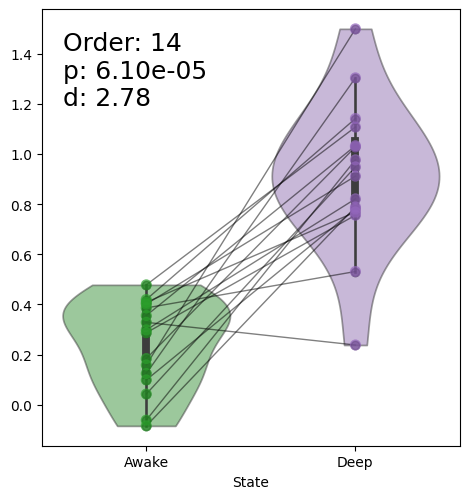

/tmp/ipykernel_12427/1819393720.py:87: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/tmp/ipykernel_12427/1819393720.py:99: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(


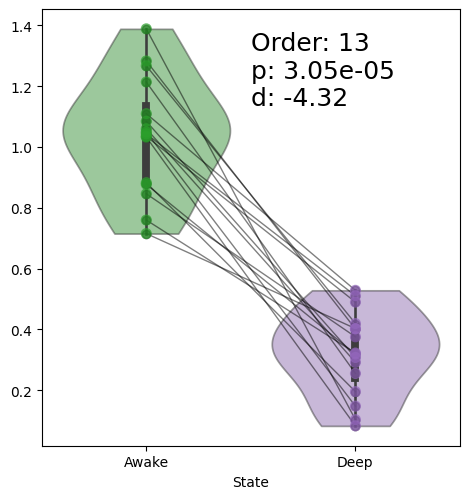

In [13]:
nplet_best_max = nplets_annealing_max[scores_annealing_max.argmax()]
nplet_best_max = np.where(nplet_best_max)[0]

plot_effect_size_contrast(Xs, nplet_best_max)

nplet_best_min = nplets_annealing_min[scores_annealing_min.argmin()]
nplet_best_min = np.where(nplet_best_min)[0]

plot_effect_size_contrast(Xs, nplet_best_min, text_left=False)

# Plot a curve of the effect size as a function of the order of interation for both (maximization and minimization)

Because with greedy we run multiple repeats and the we have multiple optimized solutions, we plot the mean and the min max error shadows

Order with maximum mean effect size: 11
Order with minimum mean effect size: 17


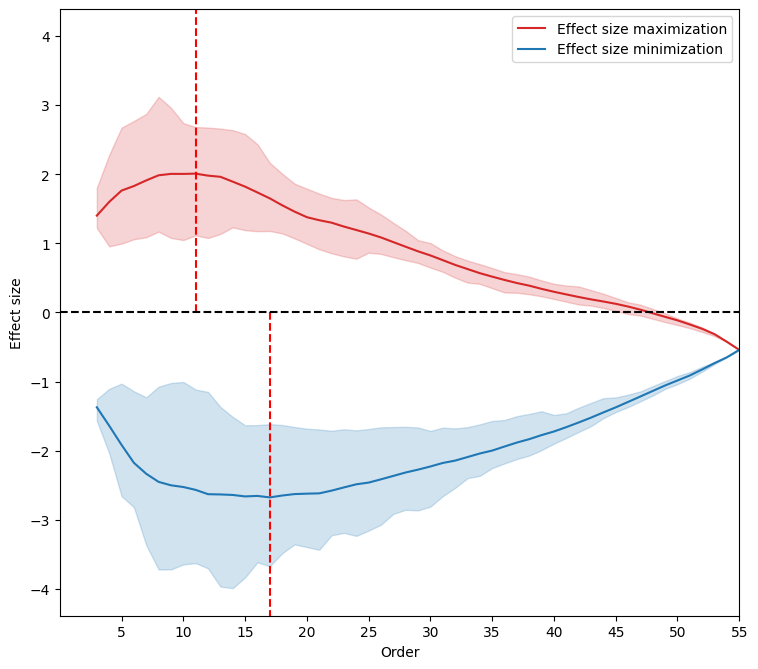

In [14]:
plot_optimized_effect_sizes_by_order(scores_greedy_max, scores_greedy_min)